# Explanation
`1826.04.Aug.20`

I came up with an SciPy-optimized turbine location for cs4 of IEA37. When presenting it to the larger group, the AEP value seemed abnormally high. I saved the locations in `.csv` format, and never converted them to `.yaml`. I will here do so, and then run it through `FlowFarm.jl` AEP calculator to verify I calculated it corectly the first time.

## Put in FlowFarm and computer AEP

In [2]:
#=== Set everything up for FlowFarm ===#
cd("/Users/nbaker/Documents/GitHub/FlowFarm.jl/test/")
include("iea37_specific_functions.jl")
#include("example_opt_4_ieacs4_bvr_ipm.jl")
include("../src/optimization_functions.jl")
include("../src/utilities.jl")
include("../src/io.jl")
include("../../FLOWMath.jl/src/interpolate.jl")
using FlowFarm; const ff = FlowFarm
import YAML
using PyPlot
using Random

#--- Read in windfarm boundary data ---#
# Which case study we're doing. 'cs3' or 'cs4'
str_case = "4"
#- Rip the boundary coordinates from the .yaml file -#
file_dir = "./inputfiles/"
bnry_file_name_orig = "iea37-boundary-cs" * str_case * ".yaml"
bnry_file_name = string(file_dir,bnry_file_name_orig)
bndry_x, bndry_y = getBndryCs4YAML(bnry_file_name)
bndry_x_clsd, bndry_y_clsd = ff.closeBndryLists(bndry_x, bndry_y)

# Place the turbines in region IIIa
layout_file_name = "./inputfiles/iea37-ex-opt4.yaml"
~, ~, fname_turb, ~ = ff.get_turb_loc_YAML(layout_file_name)
turbine_file_name = string("./inputfiles/",fname_turb)
~, ~, ~, ~, turb_diam, ~ = ff.get_turb_atrbt_YAML(turbine_file_name)
turb_min_space = 2*turb_diam

396.0

In [3]:
function printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_diam, region=0)
    #- Visualizes the farm boundaries and all turbines passed -#
    # Plot the boundary (defaults to all regions, but will do only one if specified)
    if region == 0
        for i in 1:length(bndry_x_clsd)
            plot(bndry_x_clsd[i], bndry_y_clsd[i])
        end
    else
        plot(bndry_x_clsd[region], bndry_y_clsd[region])
    end
    
    # Plot the turbines
    for i = 1:length(turbine_x)
         plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), turb_diam/2.0, fill=true,color="black"))
    #     plt.gcf().gca().add_artist(plt.Circle((test_values_x[i],test_values_y[i]), turb_diam/2.0, fill=true,color="red"))
    #     plt.text(turbine_x[i]+turb_diam,turbine_y[i]+turb_diam, string(i))
    end

    # Formatting
    axis("square")
    axis("off")
    plt.show()
end

printTurbinesInBoundary (generic function with 2 methods)

## Read in the `.csv` file

In [4]:
#- Read in the optimized .csv file -#
using CSV

file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-julia/baker-cs4-results-bpm-snopt.csv"
csv_data = CSV.File(file_name; normalizenames=true, select=[1], header=false, delim=',', type=Float64)

#println(fieldnames(typeof(thing)))
#println(thing.columns[1])

x = csv_data.columns[1]
# get number of turbines
num_turbines = Int(length(x)/2)

# extract x and y locations of turbines from design variables vector
turbine_x = x[1:num_turbines] 
turbine_y = x[num_turbines+1:end]
    
println("Read-in complete")

Read-in complete


### Visualize to check

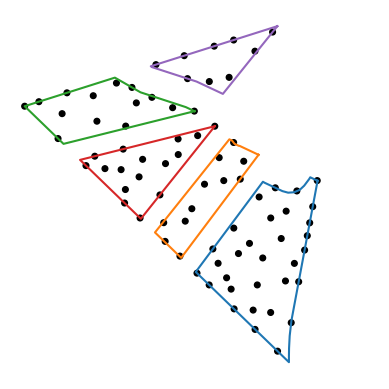

In [5]:
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_diam)
#savefig("iea37cs4-optlayout-scipy-bpm.pdf")

## Check the AEP calculations

In [10]:
#- Necessary FlowFarm Things -#
function aep_wrapper(x, params)
    # get number of turbines
    nturbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:nturbines] 
    turbine_y = x[nturbines+1:end]

    # calculate AEP
    AEP = obj_scale*ff.calculate_aep(turbine_x, turbine_y, params.turbine_z, params.rotor_diameter,
                params.hub_height, params.turbine_yaw, params.ct_models, params.generator_efficiency, params.cut_in_speed,
                params.cut_out_speed, params.rated_speed, params.rated_power, params.windresource, params.power_models, params.model_set,
                rotor_sample_points_y=params.rotor_points_y,rotor_sample_points_z=params.rotor_points_z, hours_per_year=365.0*24.0)
    
    # return the objective as an array
    return [AEP]
end

# scale objective to be between 0 and 1
obj_scale = 1#1E-9
# import model set with wind farm and related details
include("./model_sets/model_set_7_ieacs4.jl")

# set globals for use in wrapper functions
struct params_struct{}
    model_set
    rotor_points_y
    rotor_points_z
    turbine_z
    ambient_ti
    rotor_diameter
    bndry_x_clsd
    bndry_y_clsd
    num_bndry_verts
    bndry_corner_indcies
    turbs_per_region
    obj_scale
    hub_height
    turbine_yaw
    ct_models
    generator_efficiency
    cut_in_speed
    cut_out_speed
    rated_speed
    rated_power
    windresource
    power_models
end

#--- Read in random turbine locations ---#
# Make an array of the number of turbines in each region
num_regions = 5     # Number of reigons we're using (cs4 = 5, cs3 = 1)
turbs_per_region = zeros(Int8, num_regions)  # Preallocated turbines in each region
num_bndry_verts = zeros(Int8, num_regions)
for cntr in 1:num_regions
    num_bndry_verts[cntr] = length(getCs34VertList(getCs34Name(cntr)))
    turbs_per_region[cntr] = floor(getCs34NumTurbs(getCs34Name(cntr)))
end
bndry_corner_indcies = getCs34VertList("All")
num_tot_turbs = sum(turbs_per_region)

params = params_struct(model_set, rotor_points_y, rotor_points_z, turbine_z, ambient_ti, 
    rotor_diameter, bndry_x_clsd, bndry_y_clsd, num_bndry_verts, bndry_corner_indcies, turbs_per_region, obj_scale, hub_height, turbine_yaw, 
    ct_models, generator_efficiency, cut_in_speed, cut_out_speed, rated_speed, rated_power, 
    windresource, power_models)

aep_wrapper(x) = aep_wrapper(x, params)


aep_wrapper (generic function with 2 methods)

# Not Working...
`1935.04.Aug.20`

So due to my poor data recording, I've only given myself more work. The turbine locations I pulled aren't the ones that had the best value - I gave a screenshot of the layour in one of my lab meeting slides and this saved one isn't it. Unfortunately I didn't record the AEP values with the saved turbine locations (the turbine locations are just in a huge `.csv` file) so I'll have to parse through that, find the one with the bigges AEP, and plot that. Hopefully it has the correct AEP, and looks like the one I shared on my lab slide. Here we go.

## Read in and store all the turbine locations from the `bpm-3run-cs4` and get AEP vals
`1940.04.Aug.20`

Run 1: 2.8361494340269463e12
Run 2: 2.807133519453353e12


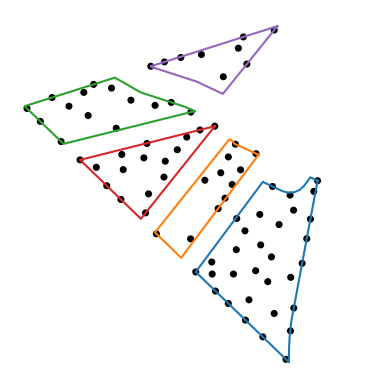

Run 3: 2.8181422508839697e12


In [15]:
#- Read in the optimized .csv file -#
file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/turblocs-bpm-3run-cs4-(0).csv"
csv_data = CSV.File(file_name; normalizenames=true, transpose=true, header=false, delim=',', type=Float64)

#println(fieldnames(typeof(thing)))
#println(thing.columns[1])

num_runs = 3 # Number of runs in this file
for i in 1:num_runs
    x = csv_data.columns[i]
    # get number of turbines
    num_turbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:num_turbines] 
    turbine_y = x[num_turbines+1:end]
    
    aepd = aep_wrapper(x, params)
    aept = sum(aepd)
    println("Run ", i, ": ", aept)
end
    
#printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_diam)

Though the decimal is off, but the numbers aren't what we were looking for (a 29 something, all these are 28...)

## Read in all the turb locs from the `bpm-20-snopt-run-cs4-(0)` and AEP
`1945.04.Aug.20`

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19


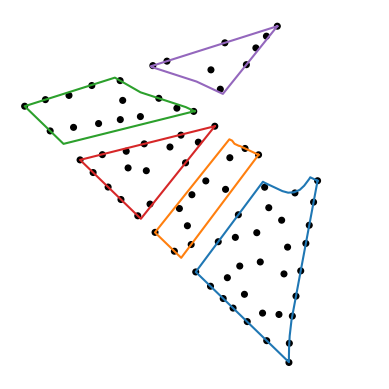

Run: 20
Best run is: 16: 2.8191009123196826e12


In [38]:
#- Read in the optimized .csv file -#
file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/turblocs-bpm-20-snopt-run-cs4-(0).csv"
csv_data = CSV.File(file_name; normalizenames=true, transpose=true, header=false, delim=',', type=Float64)

#println(fieldnames(typeof(thing)))
#println(thing.columns[1])

num_runs = 20 # Number of runs in this file
for i in 1:num_runs
    x = csv_data.columns[i]
    # get number of turbines
    num_turbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:num_turbines] 
    turbine_y = x[num_turbines+1:end]
    
    aepd = aep_wrapper(x, params)
    aept = sum(aepd)
        if aept > best_aep
        best_aep = aept
        best_indx = i
        best_x = turbine_x
        best_y = turbine_y
    end
    println("Run: ", i)
end

println("Best run is: ", best_indx, ": ", aept)
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, best_x, best_y, turb_diam)

Nope, not in there either

## Read in all the turb locs from the `bpm-20-snopt-run-cs4-(1)` and AEP
`1950.04.Aug.20`

Run: 1
Run: 2
Run: 3
Run: 4
Run: 5
Run: 6
Run: 7
Run: 8
Run: 9
Run: 10
Run: 11
Run: 12
Run: 13
Run: 14
Run: 15
Run: 16
Run: 17
Run: 18
Run: 19


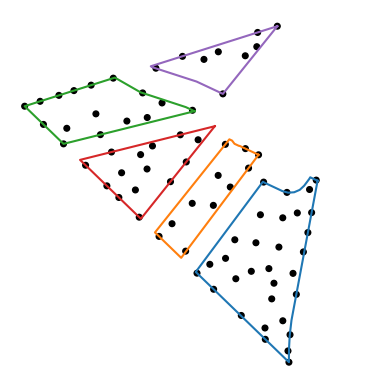

Run: 20
Best run is: 3: 2.825239298487176e12


In [37]:
#- Read in the optimized .csv file -#
file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/turblocs-bpm-20-snopt-run-cs4-(1).csv"
csv_data = CSV.File(file_name; normalizenames=true, transpose=true, header=false, delim=',', type=Float64)

#println(fieldnames(typeof(thing)))
#println(thing.columns[1])

num_runs = 20 # Number of runs in this file
best_aep = 0
best_indx = 0
best_x = zeros(Float64, 81)
best_y = zeros(Float64, 81)
for i in 1:num_runs
    x = csv_data.columns[i]
    # get number of turbines
    num_turbines = Int(length(x)/2)

    # extract x and y locations of turbines from design variables vector
    turbine_x = x[1:num_turbines] 
    turbine_y = x[num_turbines+1:end]
    
    aepd = aep_wrapper(x, params)
    aept = sum(aepd)
    if aept > best_aep
        best_aep = aept
        best_indx = i
        best_x = turbine_x
        best_y = turbine_y
    end
    println("Run: ", i)
end

println("Best run is: ", best_indx, ": ", aept)
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, best_x, best_y, turb_diam)
    

Nope, not in there either

## Where is it??
`1955.04.Aug.20`

If it's not in any of those files, it must either not exist, or be in the ones I saved seperately. I'll have to take a look. Maybe visualize all optimized locations to verify I miscalculated

`2021.04.Aug.20`

Well I found it, by taking the best AEP valuea above and printing them out. The layout matches the 16th run from `turblocs-bpm-20-snopt-run-cs4-(0).csv`. But the AEP calculation is off. The order of magnitude for the AEP is off as well, so I'll need to recalculate that instead of the 360 degree analysis, with the original one. I'll save it as a `.yaml` and run it through the original python AEP reader, and see what it gives.

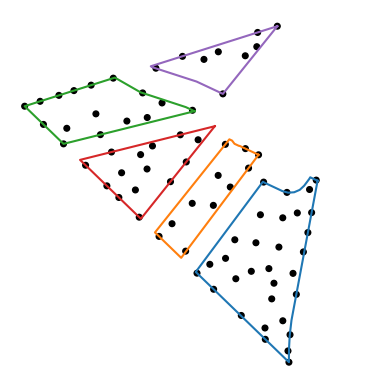

In [43]:
#- Extract the run we want, and visualize it just to make sure -#
#- Read in the optimized .csv file -#
file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/turblocs-bpm-20-snopt-run-cs4-(0).csv"
csv_data = CSV.File(file_name; normalizenames=true, transpose=true, header=false, delim=',', type=Float64)

num_run = 16 # Number of runs in this file
x = csv_data.columns[num_run]
# get number of turbines
num_turbines = Int(length(x)/2)

# extract x and y locations of turbines from design variables vector
turbine_x = x[1:num_turbines] 
turbine_y = x[num_turbines+1:end]

aepd = aep_wrapper(x, params)
aept = sum(aepd)

printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, turbine_x, turbine_y, turb_diam)
#savefig("iea37cs4-optlayout-scipy-bpm.pdf")

## Convert to `.yaml`

In [44]:
#-- Save our optimized locations --#

#- Make sure the file doesn't exit -#
directory = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/"
file_name = "iea37-opt4-snopt-bpm"
file_type = "yaml"
save_filename = getNextFileName(directory, file_name, file_type, 0)

# Necessary variables for writing turb locations
t = "IEA Wind Task 37 case study 4, BYU's BPM/SNOPT optimized layout"
td = "optimized layout for the 81 turbine wind plant model for IEA Task 37 case study 4"
tf ="iea37-10mw.yaml"
lu ="m"
wmu ="iea37-aepcalc.jl"
wrf ="iea37-windrose-cs3.yaml"
x = [copy(turbine_x);copy(turbine_y)]
aepd = aep_wrapper(x, params)
aept = sum(aepd)
aepu ="MWh"
by="./inputfiles/default.yaml"
println(aept)

# Actually write the file
write_turb_loc_YAML(save_filename, turbine_x, turbine_y; title=t, titledescription=td, 
    turbinefile=tf, locunits=lu, wakemodelused=wmu, windresourcefile=wrf, aeptotal=aept, 
    aepdirs=aepd, aepunits=aepu, baseyaml=by)


2.849847877399325e12


## Rip it from the written `.yaml` to check
`2119.04.Aug.20`

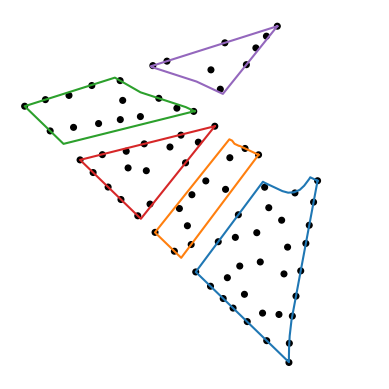

In [46]:
#- Read the just written .yaml file -#
file_name = "/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/iea37-opt4-snopt-bpm.yaml"

final_x, final_y, ~, ~ = ff.get_turb_loc_YAML(file_name)
printTurbinesInBoundary(bndry_x_clsd, bndry_y_clsd, final_x, final_y, turb_diam)
savefig("/Users/nbaker/Documents/GitHub/iea37-casestudies-extrafiles/cs3-4/optimo-attempt-baker/src-python/results/iea37-opt4-snopt-bpm.pdf")


It checks out. I'll send it to Jared and the outside guy that asked for it to check.

Again, there was no magic here. It was just SNOPT on my laptop doing a run of 20 random starts, and my "boundary partition method", what became `splined_boundary()`.